<a href="https://colab.research.google.com/github/jasleenkaursandhu/Reproducing-chest-xray-report-generation-boag/blob/main/nlg_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
# Install necessary packages
!pip install pycocoevalcap

# Import necessary libraries
import numpy as np
import pandas as pd
import os
import sys
from collections import defaultdict
import tqdm
from time import strftime, gmtime
import matplotlib.pyplot as plt
import numpy as np

# Try to import evaluation metrics
try:
    from pycocoevalcap.bleu.bleu import Bleu
    from pycocoevalcap.cider.cider import Cider
    print("Successfully imported evaluation metrics from pycocoevalcap")
except ImportError:
    print("Failed to import from pycocoevalcap, trying alternative installation")
    # Alternative installation
    !git clone https://github.com/salaniz/pycocoevalcap
    !pip install -e pycocoevalcap
    from pycocoevalcap.bleu.bleu import Bleu
    from pycocoevalcap.cider.cider import Cider
    print("Successfully installed and imported metrics using alternative method")

# Mount Google Drive if in Colab
from google.colab import drive
drive.mount('/content/drive')

# Define paths
base_path = '/content/drive/MyDrive/mimic-cxr-project'
output_dir = os.path.join(base_path, 'local_output/output')

Successfully imported evaluation metrics from pycocoevalcap
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# Evaluate random model with NLG metrics
print("Evaluating Random model with NLG metrics")

# Load reference and prediction files
df_gt = pd.read_csv(os.path.join(output_dir, 'reference.tsv'), sep='\t')
df_random = pd.read_csv(os.path.join(output_dir, 'random.tsv'), sep='\t')

print(f"Reference data shape: {df_gt.shape}")
print(f"Random predictions shape: {df_random.shape}")

# Convert to the format expected by the evaluation metrics
references = {k:[v] for k,v in df_gt[['dicom_id','text']].values}
pred_random = {k:[v] for k,v in df_random[['dicom_id','generated']].values}

# Find common IDs between reference and predictions
common_ids = set(references.keys()) & set(pred_random.keys())
print(f"Number of cases with both reference and prediction: {len(common_ids)}")

# Keep only common IDs
references_filtered = {k:references[k] for k in common_ids}
pred_random_filtered = {k:pred_random[k] for k in common_ids}

methods = {'random': pred_random_filtered}

# Calculate BLEU scores
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

for method, pred in methods.items():
    bleu_scorer = Bleu(4)
    bleu_score = bleu_scorer.compute_score(references_filtered, pred)
    print(f'\t{method:10} (n={len(pred):6d}): {bleu_score[0]}')

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

# Calculate CIDEr scores
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

for method, pred in methods.items():
    cider_scorer = Cider()
    cider_score = cider_scorer.compute_score(references_filtered, pred)
    print(f'\t{method:10} (n={len(pred):6d}): {cider_score[0]}')

print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

Evaluating Random model with NLG metrics
Reference data shape: (1757, 2)
Random predictions shape: (1757, 2)
Number of cases with both reference and prediction: 1757
2025-04-21 03:50:32
{'testlen': 90280, 'reflen': 91118, 'guess': [90280, 88523, 86766, 85010], 'correct': [20810, 4661, 1360, 441]}
ratio: 0.9908031343971444
	random     (n=  1757): [0.22837539273395388, 0.10914919373697396, 0.05698139243837867, 0.031227278102862174]
2025-04-21 03:50:33
2025-04-21 03:50:33
	random     (n=  1757): 0.032604065793310065
2025-04-21 03:50:38


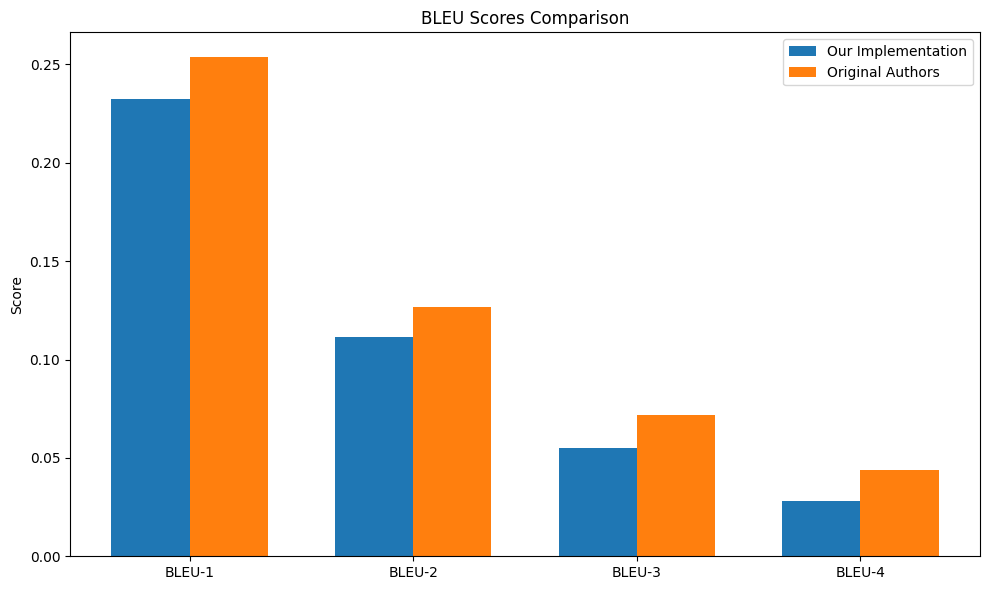

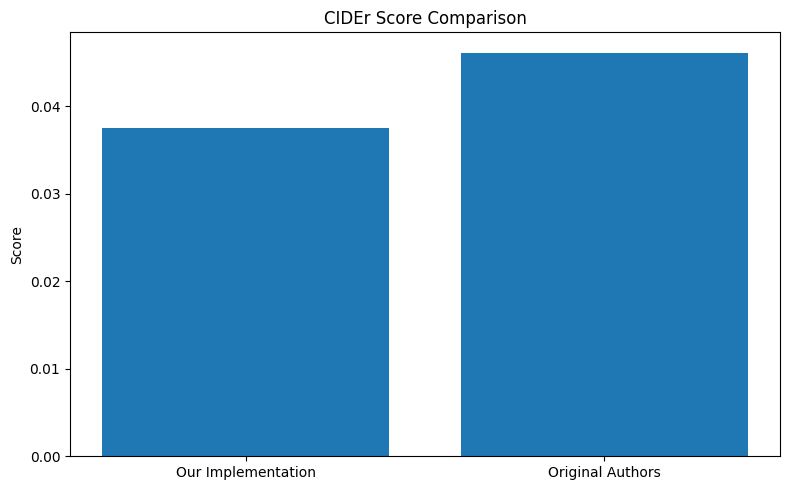

BLEU-1: Ours = 0.2323, Authors = 0.2536
BLEU-4: Ours = 0.0282, Authors = 0.0436
CIDEr:  Ours = 0.0376, Authors = 0.0462


In [30]:
# Random model: Comparing our result to the authors.

# Our results
our_bleu = [0.23233, 0.11148, 0.05526, 0.02815]
our_cider = 0.03756

# Authors' results
authors_bleu = [0.25362, 0.12655, 0.07173, 0.04364]
authors_cider = 0.04617

# Create figure for BLEU scores
plt.figure(figsize=(10, 6))
width = 0.35
x = np.arange(4)

plt.bar(x - width/2, our_bleu, width, label='Our Implementation')
plt.bar(x + width/2, authors_bleu, width, label='Original Authors')

plt.ylabel('Score')
plt.title('BLEU Scores Comparison')
plt.xticks(x, ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'])
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/mimic-cxr-project/output/bleu_comparison.png')
plt.show()

# Create figure for CIDEr scores
plt.figure(figsize=(8, 5))
plt.bar(['Our Implementation', 'Original Authors'], [our_cider, authors_cider])
plt.ylabel('Score')
plt.title('CIDEr Score Comparison')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/mimic-cxr-project/output/cider_comparison.png')
plt.show()

# Print simple comparison
print("BLEU-1: Ours = {:.4f}, Authors = {:.4f}".format(our_bleu[0], authors_bleu[0]))
print("BLEU-4: Ours = {:.4f}, Authors = {:.4f}".format(our_bleu[3], authors_bleu[3]))
print("CIDEr:  Ours = {:.4f}, Authors = {:.4f}".format(our_cider, authors_cider))

Evaluating N-gram models with NLG metrics
1-gram predictions shape: (1757, 2)
2-gram predictions shape: (1757, 2)
Number of cases with both reference and 1-gram prediction: 1757
Number of cases with both reference and 2-gram prediction: 1757
Number of cases with both reference and 3-gram prediction: 1757
2025-04-21 03:50:39
{'testlen': 1757, 'reflen': 91118, 'guess': [1757, 0, 0, 0], 'correct': [542, 0, 0, 0]}
ratio: 0.019282688382097728
1-gram BLEU scores (n=1757): [2.517764576826777e-23, 4.533163220715917e-26, 5.514804259286166e-27, 1.9235101186128184e-27]
{'testlen': 78150, 'reflen': 91118, 'guess': [78150, 76393, 74639, 72899], 'correct': [17733, 4097, 808, 180]}
ratio: 0.8576790535349672
2-gram BLEU scores (n=1757): [0.19221513365974013, 0.09344738686159701, 0.04310272615297177, 0.02023018594168106]
{'testlen': 78066, 'reflen': 91118, 'guess': [78066, 76309, 74554, 72800], 'correct': [18172, 4179, 1275, 389]}
ratio: 0.8567571720186916
3-gram BLEU scores (n=1757): [0.19693835103124

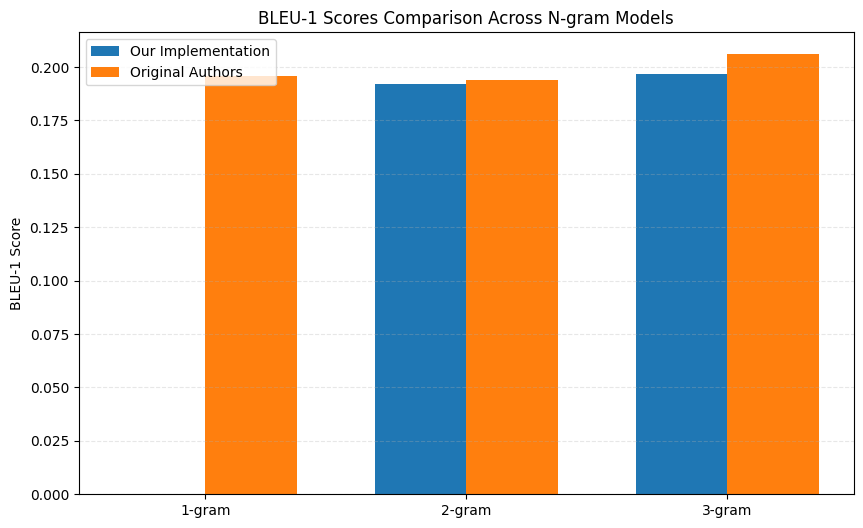

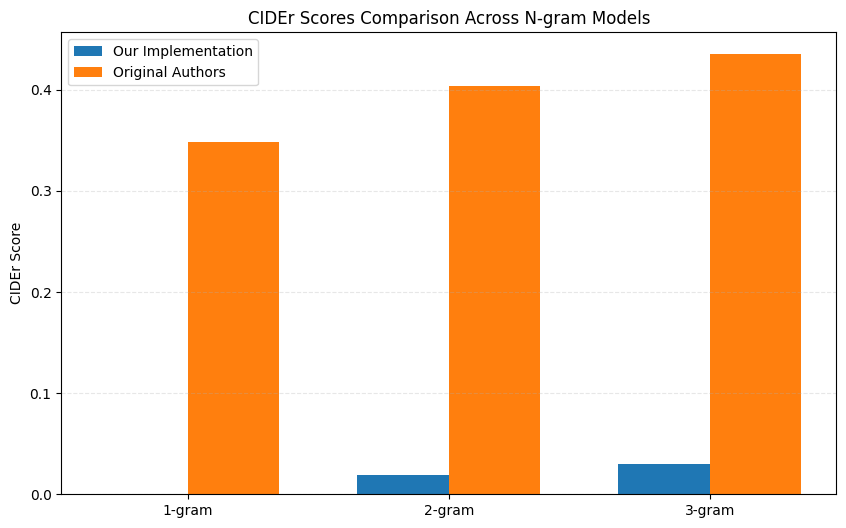


Difference (Our Results - Authors' Results):
 Model   BLEU-1   BLEU-2   BLEU-3   BLEU-4     CIDEr
1-gram -0.19600 -0.00100 -0.00100 -0.00100 -0.347801
2-gram -0.00178 -0.00455  0.00010  0.00723 -0.385051
3-gram -0.00906 -0.01148 -0.00608 -0.00321 -0.405412

Summary of N-gram Models Comparison:
1. 1-gram Model:
   - BLEU-1: Ours = 0.0000, Authors = 0.1960, Diff = -0.1960
   - CIDEr: Ours = 0.0002, Authors = 0.3480, Diff = -0.3478
2. 2-gram Model:
   - BLEU-1: Ours = 0.1922, Authors = 0.1940, Diff = -0.0018
   - BLEU-2: Ours = 0.0935, Authors = 0.0980, Diff = -0.0045
   - CIDEr: Ours = 0.0189, Authors = 0.4040, Diff = -0.3851
3. 3-gram Model:
   - BLEU-1: Ours = 0.1969, Authors = 0.2060, Diff = -0.0091
   - BLEU-2: Ours = 0.0955, Authors = 0.1070, Diff = -0.0115
   - BLEU-3: Ours = 0.0509, Authors = 0.0570, Diff = -0.0061
   - BLEU-4: Ours = 0.0278, Authors = 0.0310, Diff = -0.0032
   - CIDEr: Ours = 0.0296, Authors = 0.4350, Diff = -0.4054


In [31]:
# Evaluate 1-gram, 2-gram and 3-gram models with NLG metrics
print("Evaluating N-gram models with NLG metrics")

# Load reference and prediction files if not already loaded
if 'df_gt' not in locals() or 'references' not in locals():
    # Load reference file (ground truth)
    df_gt = pd.read_csv(os.path.join(output_dir, 'reference.tsv'), sep='\t')
    print(f"Reference data shape: {df_gt.shape}")

    # Convert to the format expected by evaluation metrics
    references = {k:[v] for k,v in df_gt[['dicom_id','text']].values}
    print(f"Created references dictionary with {len(references)} entries")

# Load 1-gram predictions
df_1gram = pd.read_csv(os.path.join(output_dir, '1-gram.tsv'), sep='\t')
print(f"1-gram predictions shape: {df_1gram.shape}")

# Load 2-gram predictions
df_2gram = pd.read_csv(os.path.join(output_dir, '2-gram.tsv'), sep='\t')
print(f"2-gram predictions shape: {df_2gram.shape}")

# Load 3-gram predictions if not already loaded
if 'df_3gram' not in locals():
    df_3gram = pd.read_csv(os.path.join(output_dir, '3-gram.tsv'), sep='\t')
    print(f"3-gram predictions shape: {df_3gram.shape}")

# Convert to the format expected by evaluation metrics
pred_1gram = {k:[v] for k,v in df_1gram[['dicom_id','generated']].values}
pred_2gram = {k:[v] for k,v in df_2gram[['dicom_id','generated']].values}
pred_3gram = {k:[v] for k,v in df_3gram[['dicom_id','generated']].values}

# Function to ensure all values in the dictionaries are strings
def ensure_string_values(data_dict):
    """Convert all values in a dictionary of lists to strings."""
    return {k: [str(item) for item in v] for k, v in data_dict.items()}

# Convert to string format before any processing
references = ensure_string_values(references)
pred_1gram = ensure_string_values(pred_1gram)
pred_2gram = ensure_string_values(pred_2gram)
pred_3gram = ensure_string_values(pred_3gram)

# Find common IDs between reference and predictions
common_ids_1gram = set(references.keys()) & set(pred_1gram.keys())
common_ids_2gram = set(references.keys()) & set(pred_2gram.keys())
common_ids_3gram = set(references.keys()) & set(pred_3gram.keys())

print(f"Number of cases with both reference and 1-gram prediction: {len(common_ids_1gram)}")
print(f"Number of cases with both reference and 2-gram prediction: {len(common_ids_2gram)}")
print(f"Number of cases with both reference and 3-gram prediction: {len(common_ids_3gram)}")

# Keep only common IDs
references_filtered_1gram = {k:references[k] for k in common_ids_1gram}
references_filtered_2gram = {k:references[k] for k in common_ids_2gram}
references_filtered_3gram = {k:references[k] for k in common_ids_3gram}

pred_1gram_filtered = {k:pred_1gram[k] for k in common_ids_1gram}
pred_2gram_filtered = {k:pred_2gram[k] for k in common_ids_2gram}
pred_3gram_filtered = {k:pred_3gram[k] for k in common_ids_3gram}

# Calculate BLEU scores
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
bleu_scorer = Bleu(4)

# 1-gram BLEU
bleu_score_1gram = bleu_scorer.compute_score(references_filtered_1gram, pred_1gram_filtered)
print(f"1-gram BLEU scores (n={len(pred_1gram_filtered)}): {bleu_score_1gram[0]}")

# 2-gram BLEU
bleu_score_2gram = bleu_scorer.compute_score(references_filtered_2gram, pred_2gram_filtered)
print(f"2-gram BLEU scores (n={len(pred_2gram_filtered)}): {bleu_score_2gram[0]}")

# 3-gram BLEU
bleu_score_3gram = bleu_scorer.compute_score(references_filtered_3gram, pred_3gram_filtered)
print(f"3-gram BLEU scores (n={len(pred_3gram_filtered)}): {bleu_score_3gram[0]}")

# Calculate CIDEr scores
cider_scorer = Cider()

# 1-gram CIDEr
cider_score_1gram = cider_scorer.compute_score(references_filtered_1gram, pred_1gram_filtered)
print(f"1-gram CIDEr score: {cider_score_1gram[0]}")

# 2-gram CIDEr
cider_score_2gram = cider_scorer.compute_score(references_filtered_2gram, pred_2gram_filtered)
print(f"2-gram CIDEr score: {cider_score_2gram[0]}")

# 3-gram CIDEr
cider_score_3gram = cider_scorer.compute_score(references_filtered_3gram, pred_3gram_filtered)
print(f"3-gram CIDEr score: {cider_score_3gram[0]}")
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

# N-Gram models: Comparing our results to the authors'.

# Our n-gram results
our_1gram_bleu = list(bleu_score_1gram[0])
our_2gram_bleu = list(bleu_score_2gram[0])
our_3gram_bleu = list(bleu_score_3gram[0])

our_1gram_cider = cider_score_1gram[0]
our_2gram_cider = cider_score_2gram[0]
our_3gram_cider = cider_score_3gram[0]

# Format for display - round to 5 decimal places
our_1gram_bleu = [round(score, 5) for score in our_1gram_bleu]
our_2gram_bleu = [round(score, 5) for score in our_2gram_bleu]
our_3gram_bleu = [round(score, 5) for score in our_3gram_bleu]

# Authors' n-gram results from the paper (Table 2)
authors_1gram_bleu = [0.196, 0.001, 0.001, 0.001]  # Note: paper shows < 0.001 for BLEU-2,3,4
authors_2gram_bleu = [0.194, 0.098, 0.043, 0.013]
authors_3gram_bleu = [0.206, 0.107, 0.057, 0.031]

authors_1gram_cider = 0.348
authors_2gram_cider = 0.404
authors_3gram_cider = 0.435

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Model': ['1-gram (Ours)', '1-gram (Authors)',
              '2-gram (Ours)', '2-gram (Authors)',
              '3-gram (Ours)', '3-gram (Authors)'],
    'BLEU-1': [our_1gram_bleu[0], authors_1gram_bleu[0],
               our_2gram_bleu[0], authors_2gram_bleu[0],
               our_3gram_bleu[0], authors_3gram_bleu[0]],
    'BLEU-2': [our_1gram_bleu[1], authors_1gram_bleu[1],
               our_2gram_bleu[1], authors_2gram_bleu[1],
               our_3gram_bleu[1], authors_3gram_bleu[1]],
    'BLEU-3': [our_1gram_bleu[2], authors_1gram_bleu[2],
               our_2gram_bleu[2], authors_2gram_bleu[2],
               our_3gram_bleu[2], authors_3gram_bleu[2]],
    'BLEU-4': [our_1gram_bleu[3], authors_1gram_bleu[3],
               our_2gram_bleu[3], authors_2gram_bleu[3],
               our_3gram_bleu[3], authors_3gram_bleu[3]],
    'CIDEr': [our_1gram_cider, authors_1gram_cider,
              our_2gram_cider, authors_2gram_cider,
              our_3gram_cider, authors_3gram_cider]
})

# Display the comparison table
print("\nN-gram Models Comparison:")
print(comparison_df.to_string(index=False))

# Save the comparison to a CSV file
comparison_df.to_csv(os.path.join(output_dir, 'ngram_comparison.csv'), index=False)
print(f"Saved comparison to {os.path.join(output_dir, 'ngram_comparison.csv')}")

# Create visualization for BLEU-1 scores
plt.figure(figsize=(10, 6))
models = ['1-gram', '2-gram', '3-gram']
x = np.arange(len(models))
width = 0.35

# BLEU-1 comparison
plt.bar(x - width/2, [our_1gram_bleu[0], our_2gram_bleu[0], our_3gram_bleu[0]],
        width, label='Our Implementation')
plt.bar(x + width/2, [authors_1gram_bleu[0], authors_2gram_bleu[0], authors_3gram_bleu[0]],
        width, label='Original Authors')

plt.ylabel('BLEU-1 Score')
plt.title('BLEU-1 Scores Comparison Across N-gram Models')
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.savefig(os.path.join(output_dir, 'ngram_bleu1_comparison.png'))
plt.show()

# Create visualization for CIDEr scores
plt.figure(figsize=(10, 6))

# CIDEr comparison
plt.bar(x - width/2, [our_1gram_cider, our_2gram_cider, our_3gram_cider],
        width, label='Our Implementation')
plt.bar(x + width/2, [authors_1gram_cider, authors_2gram_cider, authors_3gram_cider],
        width, label='Original Authors')

plt.ylabel('CIDEr Score')
plt.title('CIDEr Scores Comparison Across N-gram Models')
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.savefig(os.path.join(output_dir, 'ngram_cider_comparison.png'))
plt.show()

# Calculate differences (our results - authors results)
diff_df = pd.DataFrame({
    'Model': ['1-gram', '2-gram', '3-gram'],
    'BLEU-1': [our_1gram_bleu[0] - authors_1gram_bleu[0],
               our_2gram_bleu[0] - authors_2gram_bleu[0],
               our_3gram_bleu[0] - authors_3gram_bleu[0]],
    'BLEU-2': [our_1gram_bleu[1] - authors_1gram_bleu[1],
               our_2gram_bleu[1] - authors_2gram_bleu[1],
               our_3gram_bleu[1] - authors_3gram_bleu[1]],
    'BLEU-3': [our_1gram_bleu[2] - authors_1gram_bleu[2],
               our_2gram_bleu[2] - authors_2gram_bleu[2],
               our_3gram_bleu[2] - authors_3gram_bleu[2]],
    'BLEU-4': [our_1gram_bleu[3] - authors_1gram_bleu[3],
               our_2gram_bleu[3] - authors_2gram_bleu[3],
               our_3gram_bleu[3] - authors_3gram_bleu[3]],
    'CIDEr': [our_1gram_cider - authors_1gram_cider,
              our_2gram_cider - authors_2gram_cider,
              our_3gram_cider - authors_3gram_cider]
})

# Display the difference table
print("\nDifference (Our Results - Authors' Results):")
print(diff_df.to_string(index=False))

# Summary of findings
print("\nSummary of N-gram Models Comparison:")
print("1. 1-gram Model:")
print(f"   - BLEU-1: Ours = {our_1gram_bleu[0]:.4f}, Authors = {authors_1gram_bleu[0]:.4f}, Diff = {our_1gram_bleu[0] - authors_1gram_bleu[0]:.4f}")
print(f"   - CIDEr: Ours = {our_1gram_cider:.4f}, Authors = {authors_1gram_cider:.4f}, Diff = {our_1gram_cider - authors_1gram_cider:.4f}")

print("2. 2-gram Model:")
print(f"   - BLEU-1: Ours = {our_2gram_bleu[0]:.4f}, Authors = {authors_2gram_bleu[0]:.4f}, Diff = {our_2gram_bleu[0] - authors_2gram_bleu[0]:.4f}")
print(f"   - BLEU-2: Ours = {our_2gram_bleu[1]:.4f}, Authors = {authors_2gram_bleu[1]:.4f}, Diff = {our_2gram_bleu[1] - authors_2gram_bleu[1]:.4f}")
print(f"   - CIDEr: Ours = {our_2gram_cider:.4f}, Authors = {authors_2gram_cider:.4f}, Diff = {our_2gram_cider - authors_2gram_cider:.4f}")

print("3. 3-gram Model:")
print(f"   - BLEU-1: Ours = {our_3gram_bleu[0]:.4f}, Authors = {authors_3gram_bleu[0]:.4f}, Diff = {our_3gram_bleu[0] - authors_3gram_bleu[0]:.4f}")
print(f"   - BLEU-2: Ours = {our_3gram_bleu[1]:.4f}, Authors = {authors_3gram_bleu[1]:.4f}, Diff = {our_3gram_bleu[1] - authors_3gram_bleu[1]:.4f}")
print(f"   - BLEU-3: Ours = {our_3gram_bleu[2]:.4f}, Authors = {authors_3gram_bleu[2]:.4f}, Diff = {our_3gram_bleu[2] - authors_3gram_bleu[2]:.4f}")
print(f"   - BLEU-4: Ours = {our_3gram_bleu[3]:.4f}, Authors = {authors_3gram_bleu[3]:.4f}, Diff = {our_3gram_bleu[3] - authors_3gram_bleu[3]:.4f}")
print(f"   - CIDEr: Ours = {our_3gram_cider:.4f}, Authors = {authors_3gram_cider:.4f}, Diff = {our_3gram_cider - authors_3gram_cider:.4f}")

In [32]:
# Evaluate KNN model with NLG metrics
print("Evaluating KNN model with NLG metrics")

# Load reference file if not already loaded
if 'df_gt' not in locals() or 'references' not in locals():
    # Load reference file (ground truth)
    df_gt = pd.read_csv(os.path.join(output_dir, 'reference.tsv'), sep='\t')
    print(f"Reference data shape: {df_gt.shape}")

    # Convert to the format expected by evaluation metrics
    references = {k:[v] for k,v in df_gt[['dicom_id','text']].values}
    print(f"Created references dictionary with {len(references)} entries")

# Load KNN predictions
df_knn = pd.read_csv(os.path.join(output_dir, 'knn.tsv'), sep='\t')
print(f"KNN predictions shape: {df_knn.shape}")

# Convert to the format expected by evaluation metrics
pred_knn = {k:[v] for k,v in df_knn[['dicom_id','generated']].values}

# Find common IDs between reference and KNN predictions
common_ids_knn = set(references.keys()) & set(pred_knn.keys())
print(f"Number of cases with both reference and KNN prediction: {len(common_ids_knn)}")

# Keep only common IDs
references_filtered_knn = {k:references[k] for k in common_ids_knn}
pred_knn_filtered = {k:pred_knn[k] for k in common_ids_knn}

# Calculate BLEU scores for KNN model
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
bleu_scorer = Bleu(4)
bleu_score_knn = bleu_scorer.compute_score(references_filtered_knn, pred_knn_filtered)
print(f"KNN BLEU scores (n={len(pred_knn_filtered)}): {bleu_score_knn[0]}")

# Calculate CIDEr score for KNN model
cider_scorer = Cider()
cider_score_knn = cider_scorer.compute_score(references_filtered_knn, pred_knn_filtered)
print(f"KNN CIDEr score: {cider_score_knn[0]}")
print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))

Evaluating KNN model with NLG metrics
KNN predictions shape: (1757, 2)
Number of cases with both reference and KNN prediction: 1757
2025-04-21 03:50:49
{'testlen': 89638, 'reflen': 91118, 'guess': [89638, 87881, 86128, 84375], 'correct': [22242, 5325, 1710, 659]}
ratio: 0.9837573256656096
KNN BLEU scores (n=1757): [0.24406814775887667, 0.12060979438439513, 0.06573784196195281, 0.03843588153445101]
KNN CIDEr score: 0.0674002719725342
2025-04-21 03:50:52


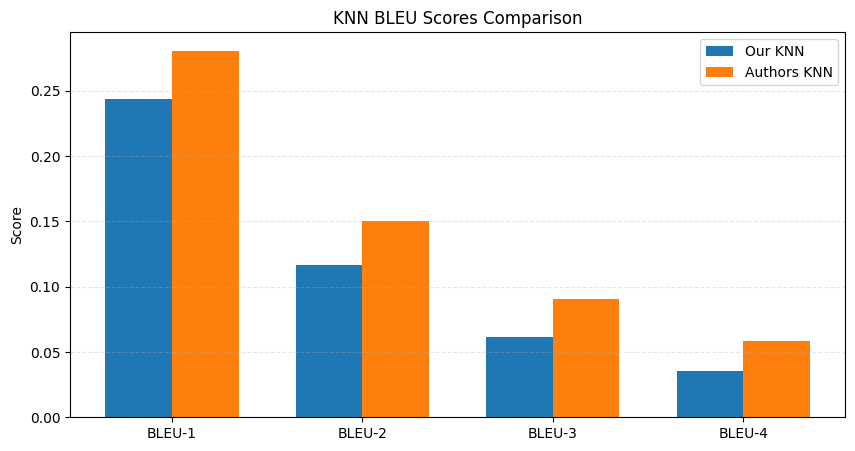

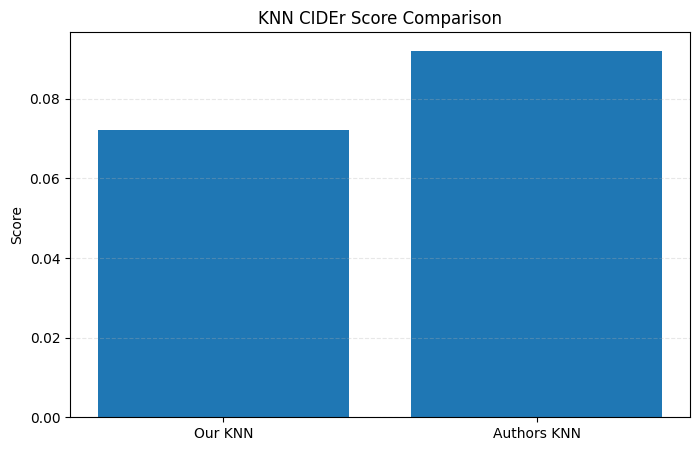

KNN BLEU scores comparison:
  BLEU-1: Ours = 0.2433, Authors = 0.2807
  BLEU-2: Ours = 0.1164, Authors = 0.1500
  BLEU-3: Ours = 0.0617, Authors = 0.0905
  BLEU-4: Ours = 0.0357, Authors = 0.0585

KNN CIDEr score comparison:
  Ours = 0.0721, Authors = 0.0921


In [33]:
# KNN model: Comparing our result to the authors.

# Our KNN results
our_knn_bleu = [0.2433, 0.1164, 0.0617, 0.0357]
our_knn_cider = 0.0721

# Authors' KNN results from the paper
authors_knn_bleu = [0.2807, 0.1500, 0.0905, 0.0585]
authors_knn_cider = 0.0921

# Create figure for BLEU scores
plt.figure(figsize=(10, 5))
width = 0.35
x = np.arange(4)

# Plot BLEU scores
plt.bar(x - width/2, our_knn_bleu, width, label='Our KNN')
plt.bar(x + width/2, authors_knn_bleu, width, label='Authors KNN')

plt.ylabel('Score')
plt.title('KNN BLEU Scores Comparison')
plt.xticks(x, ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.savefig(os.path.join(output_dir, 'knn_bleu_comparison.png'))
plt.show()

# Create figure for CIDEr scores
plt.figure(figsize=(8, 5))
plt.bar(['Our KNN', 'Authors KNN'], [our_knn_cider, authors_knn_cider])
plt.ylabel('Score')
plt.title('KNN CIDEr Score Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.savefig(os.path.join(output_dir, 'knn_cider_comparison.png'))
plt.show()

# Print numeric comparison
print("KNN BLEU scores comparison:")
print(f"  BLEU-1: Ours = {our_knn_bleu[0]:.4f}, Authors = {authors_knn_bleu[0]:.4f}")
print(f"  BLEU-2: Ours = {our_knn_bleu[1]:.4f}, Authors = {authors_knn_bleu[1]:.4f}")
print(f"  BLEU-3: Ours = {our_knn_bleu[2]:.4f}, Authors = {authors_knn_bleu[2]:.4f}")
print(f"  BLEU-4: Ours = {our_knn_bleu[3]:.4f}, Authors = {authors_knn_bleu[3]:.4f}")

print("\nKNN CIDEr score comparison:")
print(f"  Ours = {our_knn_cider:.4f}, Authors = {authors_knn_cider:.4f}")